In [1]:
import numpy as np 
import pandas as pd
import pydotplus
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Train a Random Forest Regressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# Print out a quick overview of the data
dataset=pd.read_csv("dataset.csv")
dataset.head()
dataset.drop('URL', axis=1, inplace=True) # Drop the URL column since that is a unique column for training
print(dataset.isnull().sum())
dataset[pd.isnull(dataset).any(axis=1)]
dataset.describe(include='all') # Quick statistical summary of data
dataset = dataset.interpolate()
print(dataset.isnull().sum())
dataset['SERVER'].fillna('RARE_VALUE', inplace=True)
dataset_random_forest = pd.get_dummies(dataset,prefix_sep='--')
print(dataset_random_forest.head())

# Separate predictors and response
X = dataset_random_forest.drop('Type',axis=1) #Predictors
y = dataset_random_forest['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Get a training and test dataset

# n_estimators is the number of random forests to use
# n_jobs says to use all processors available
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=30, criterion = 'entropy')
rf.fit(X_train, y_train)
print('Training Accuracy Score: {}'.format(rf.score(X_train, y_train)))
y_pred = rf.predict(X_test)



URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       1
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_P

In [2]:
# Visualize our results
def print_score(classifier,X_train,y_train,X_test,y_test,train=True):
    if train == True:
        print("Training results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,classifier.predict(X_train))))
        print('Classification Report:\n{}\n'.format(classification_report(y_train,classifier.predict(X_train))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_train,classifier.predict(X_train))))
        res = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
        print('Average Accuracy:\t{0:.4f}\n'.format(res.mean()))
        print('Standard Deviation:\t{0:.4f}'.format(res.std()))
    elif train == False:
        print("Test results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_test,classifier.predict(X_test))))
        print('Classification Report:\n{}\n'.format(classification_report(y_test,classifier.predict(X_test))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_test,classifier.predict(X_test))))
print_score(rf,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9524

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       306
           1       1.00      0.67      0.80        51

   micro avg       0.95      0.95      0.95       357
   macro avg       0.97      0.83      0.89       357
weighted avg       0.95      0.95      0.95       357


Confusion Matrix:
[[306   0]
 [ 17  34]]



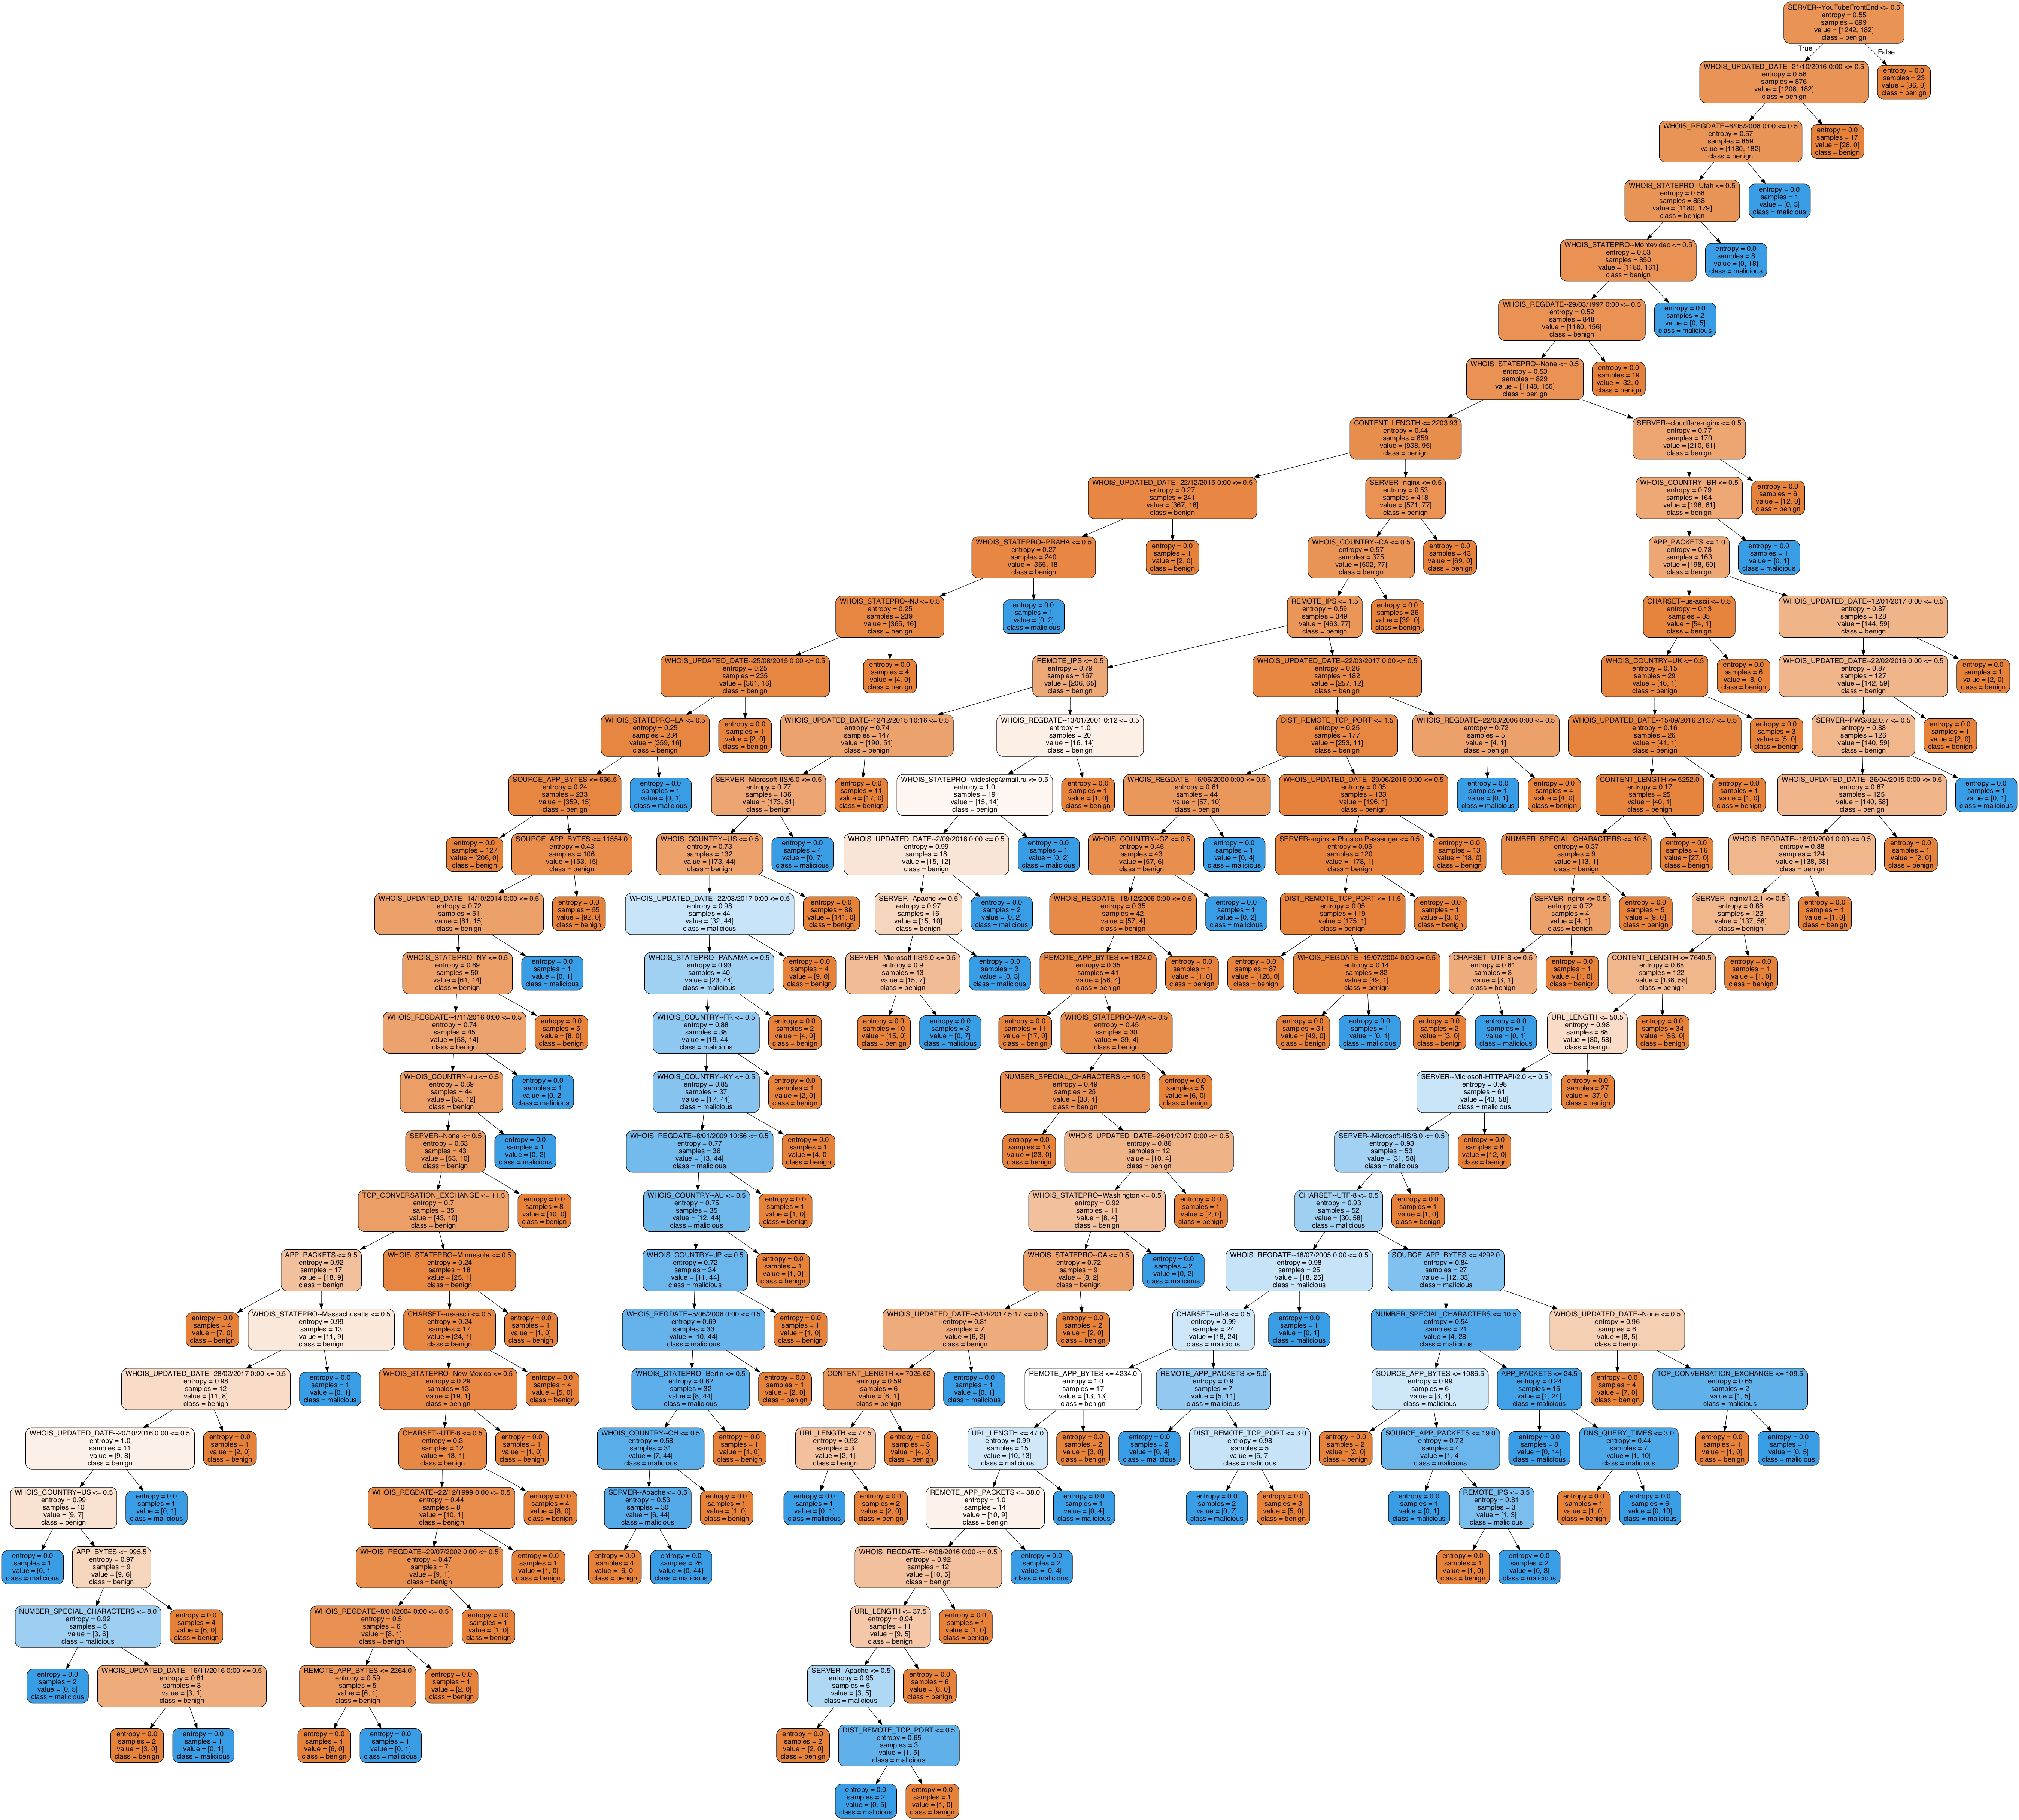

In [3]:
dot_data = StringIO()
def create_graph(forest, feature_names):
    estimator = forest.estimators_[5]
    
    export_graphviz(estimator, out_file=dot_data,
                    feature_names = feature_names,
                    class_names = ['benign','malicious'],
                    rounded = True, proportion = False, precision = 2, filled = True)
    
create_graph(rf, list(X))
# Display in jupyter notebook.view()
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [4]:
# View our feature importances
feature_importance_zip = zip(list(X), rf.feature_importances_)
# Sort the feature_importance_zip
sorted_importance = sorted(feature_importance_zip, key=lambda x: x[1], reverse=True)
for feature in sorted_importance[:15]:
    print(feature)

('DIST_REMOTE_TCP_PORT', 0.05342660646308318)
('REMOTE_APP_PACKETS', 0.04889804798618434)
('SOURCE_APP_BYTES', 0.044994408762751216)
('WHOIS_UPDATED_DATE--2/09/2016 0:00', 0.041785525047550204)
('URL_LENGTH', 0.04059871949908813)
('REMOTE_APP_BYTES', 0.03686639564038893)
('WHOIS_REGDATE--17/09/2008 0:00', 0.036251609097181114)
('WHOIS_COUNTRY--ES', 0.03260377611024808)
('APP_PACKETS', 0.03101043523535775)
('WHOIS_STATEPRO--Barcelona', 0.030013893564596068)
('SOURCE_APP_PACKETS', 0.029356248305342475)
('TCP_CONVERSATION_EXCHANGE', 0.02615584898768136)
('CONTENT_LENGTH', 0.02594562558464115)
('NUMBER_SPECIAL_CHARACTERS', 0.025383050064227485)
('WHOIS_UPDATED_DATE--None', 0.024697052997212917)


In [5]:
# Look at our feature importances without the dummy variables
original_feature_dict = {}
for feature, importance in zip(list(X), rf.feature_importances_):
    # Check for our dummy variable delimeter --
    if '--' in feature:
        original_feature_name = feature.split('--')[0]
    else:
        original_feature_name = feature
        
    # Add to our original_feature_dict, incrememnt if it's already there
    if original_feature_name in original_feature_dict:
        original_feature_dict[original_feature_name] += importance
    else:
        original_feature_dict[original_feature_name] = importance
      
# sort the original_feature_dict
sorted_importance = sorted(original_feature_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(feature, importance)
    

WHOIS_UPDATED_DATE 0.1384913052591204
WHOIS_REGDATE 0.13239822012929642
WHOIS_STATEPRO 0.09738419558959541
SERVER 0.08626458848099115
WHOIS_COUNTRY 0.08311912743467331
DIST_REMOTE_TCP_PORT 0.05342660646308318
REMOTE_APP_PACKETS 0.04889804798618434
SOURCE_APP_BYTES 0.044994408762751216
URL_LENGTH 0.04059871949908813
REMOTE_APP_BYTES 0.03686639564038893
CHARSET 0.03622444074500446
APP_PACKETS 0.03101043523535775
SOURCE_APP_PACKETS 0.029356248305342475
TCP_CONVERSATION_EXCHANGE 0.02615584898768136
CONTENT_LENGTH 0.02594562558464115
NUMBER_SPECIAL_CHARACTERS 0.025383050064227485
APP_BYTES 0.02277234619504461
DNS_QUERY_TIMES 0.020739147082822575
REMOTE_IPS 0.019971242554705712


In [6]:
import numpy as np 
import pandas as pd
import pydotplus
import graphviz
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Train a Random Forest Regressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# Copy over our data so we don't overwrite the original results if we want dimensionality reduction
dataset_preprocessed = dataset
# Converting server types with only 1 unique count to a RARE_VALUE for classification
test = dataset_preprocessed ['SERVER'].value_counts()
col = 'SERVER'
dataset_preprocessed.loc[dataset_preprocessed[col].value_counts()[dataset_preprocessed[col]].values < 2, col] = "RARE_VALUE"
# Function to extract the registration year
def extract_reg_year(x):
    # If no year was reported, leave it as None
    if str(x) == 'None':
        return(x)        
    parse_error = False  # Try different parses for different date formats
    try:
        date = x.split(' ')[0]
        year = date.split('/')[2]
    except:
        parse_error = True    
    
    if parse_error:  # One more date format to try if there's a parse error
        try:
            date = x.split('T')[0]
            year = date.split('-')[0]
            parse_error = False
        except:
            parse_error = True
            raise ValueError('Error parsing {}'.format(x))
    return(year)
dataset_preprocessed['WHOIS_REGDATE'] = dataset_preprocessed['WHOIS_REGDATE'].apply(extract_reg_year)
dataset_preprocessed['WHOIS_UPDATED_DATE'] = dataset_preprocessed['WHOIS_UPDATED_DATE'].apply(extract_reg_year)

# State without country doesn't make sense
dataset_preprocessed['WHOIS_STATEPRO'] = dataset_preprocessed[['WHOIS_COUNTRY','WHOIS_STATEPRO']].apply(lambda x : '{}-{}'.format(x[0],x[1]), axis=1)
dataset_preprocessed.describe(include='all')

# As above, create our random forest classifier the same way, Convert categorical columns to numbered categorical columns
dataset_pp_with_dummies = pd.get_dummies(dataset_preprocessed, prefix_sep='--')  # Separate predictors and response
X_pp = dataset_pp_with_dummies.drop('Type',axis=1) #Predictors
y_pp = dataset_pp_with_dummies['Type']

# Get a training and test dataset
X_pp_train, X_pp_test, y_pp_train, y_pp_test = train_test_split(X_pp, y_pp, test_size=0.2, random_state=42)

# n_estimators is the number of random forests to use, n_jobs says to use all processors available
# Properties we can play with for the RandomForestClassifier function:
rf_pp = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=30, criterion = 'entropy')
rf_pp.fit(X_pp_train, y_pp_train)

print('Training Accuracy Score: {}'.format(rf_pp.score(X_pp_train, y_pp_train)))
y_pp_pred = rf_pp.predict(X_pp_test)
print_score(rf_pp,X_pp_train,y_pp_train,X_pp_test,y_pp_test,train=False)

Training Accuracy Score: 1.0
Test results:

Accuracy Score: 0.9552

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       306
           1       1.00      0.69      0.81        51

   micro avg       0.96      0.96      0.96       357
   macro avg       0.98      0.84      0.89       357
weighted avg       0.96      0.96      0.95       357


Confusion Matrix:
[[306   0]
 [ 16  35]]



In [7]:
feature_importance_zip = zip(list(X_pp), rf_pp.feature_importances_) # View our feature importances
sorted_importance = sorted(feature_importance_zip, key=lambda x: x[1], reverse=True) # Sort the feature_importance_zip
for feature in sorted_importance[:15]:
    print(feature)

('DIST_REMOTE_TCP_PORT', 0.06646837813869216)
('SOURCE_APP_BYTES', 0.06483437316657457)
('WHOIS_STATEPRO--ES-Barcelona', 0.053784759765605684)
('REMOTE_APP_PACKETS', 0.05345794538693188)
('URL_LENGTH', 0.05224227267946568)
('NUMBER_SPECIAL_CHARACTERS', 0.040305478299196285)
('REMOTE_APP_BYTES', 0.03795706232501489)
('WHOIS_COUNTRY--ES', 0.037334199848768616)
('CONTENT_LENGTH', 0.032868462087044734)
('APP_PACKETS', 0.0317267193851686)
('APP_BYTES', 0.031422119192630535)
('SOURCE_APP_PACKETS', 0.031073532544015018)
('REMOTE_IPS', 0.030380231847963887)
('DNS_QUERY_TIMES', 0.02637787941070126)
('WHOIS_REGDATE--2008', 0.023673932468653777)


In [8]:
# Look at our feature importances without the dummy variables
original_feature_dict = {}
for feature, importance in zip(list(X_pp), rf_pp.feature_importances_):
    # Check for our dummy variable delimeter --
    if '--' in feature:
        original_feature_name = feature.split('--')[0]
    else:
        original_feature_name = feature
        
    # Add to our original_feature_dict, incrememnt if it's already there
    if original_feature_name in original_feature_dict:
        original_feature_dict[original_feature_name] += importance
    else:
        original_feature_dict[original_feature_name] = importance
      
# Sort the original_feature_dict
sorted_importance = sorted(original_feature_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(feature, importance)

WHOIS_STATEPRO 0.13144617601555986
SERVER 0.08988773185546672
WHOIS_COUNTRY 0.0872292975196053
WHOIS_REGDATE 0.08382526653440113
DIST_REMOTE_TCP_PORT 0.06646837813869216
SOURCE_APP_BYTES 0.06483437316657457
REMOTE_APP_PACKETS 0.05345794538693188
URL_LENGTH 0.05224227267946568
WHOIS_UPDATED_DATE 0.048021295307439205
NUMBER_SPECIAL_CHARACTERS 0.040305478299196285
REMOTE_APP_BYTES 0.03795706232501489
CHARSET 0.03756778805582537
CONTENT_LENGTH 0.032868462087044734
APP_PACKETS 0.0317267193851686
APP_BYTES 0.031422119192630535
SOURCE_APP_PACKETS 0.031073532544015018
REMOTE_IPS 0.030380231847963887
DNS_QUERY_TIMES 0.02637787941070126
TCP_CONVERSATION_EXCHANGE 0.022907990248302965


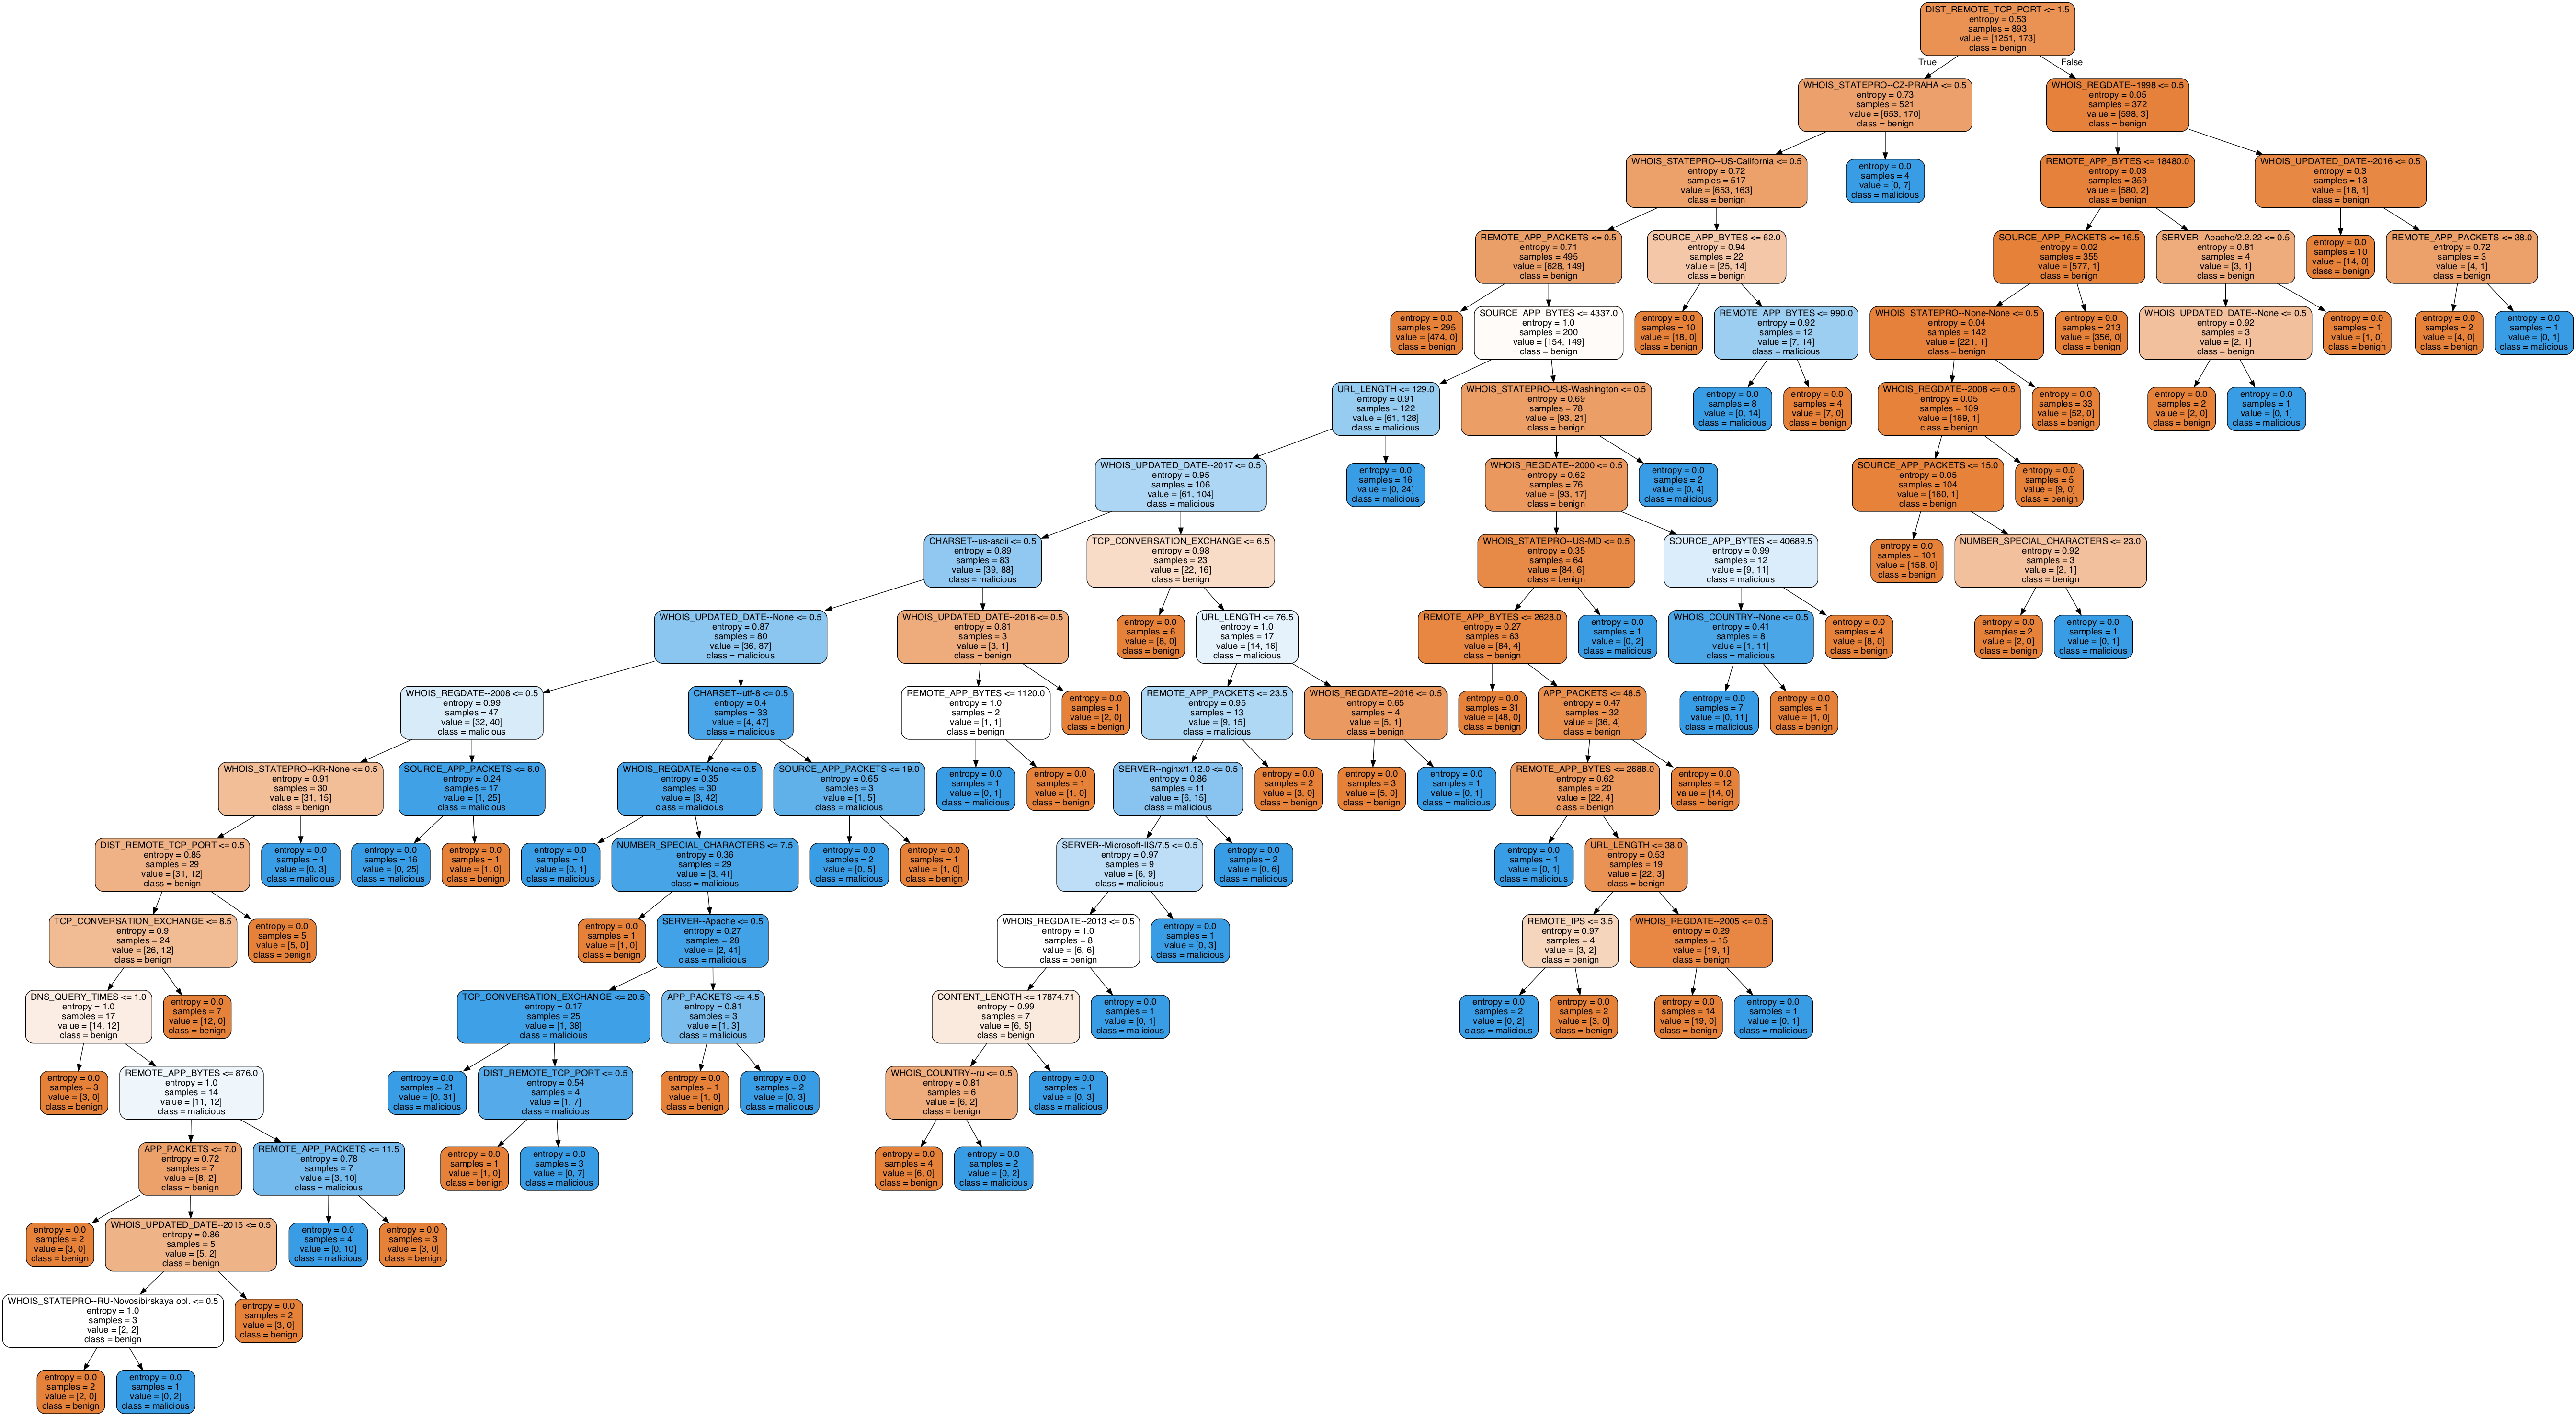

In [9]:
dot_data = StringIO()

create_graph(rf_pp, list(X_pp))
# Display in jupyter notebook
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

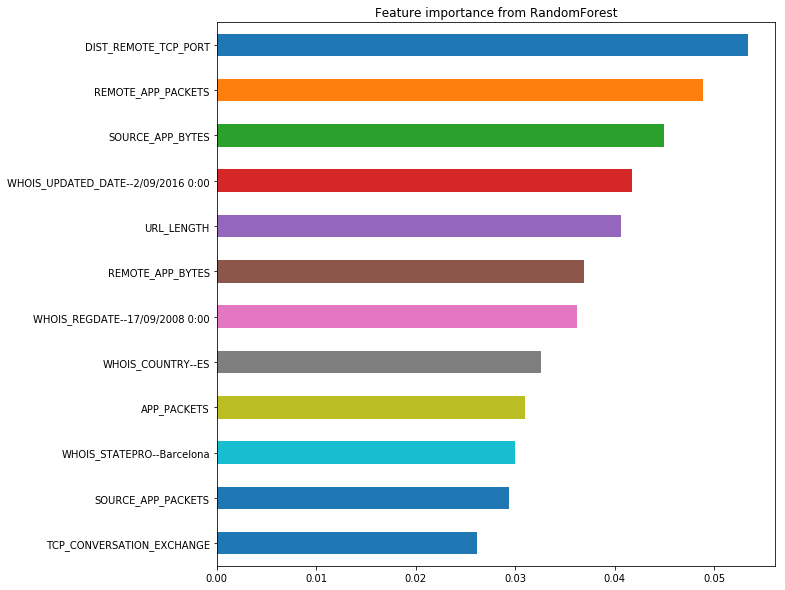

In [10]:
#feature_importance_without_dimentionality_reduction
pd.Series(rf.feature_importances_, index = X_train.columns).nlargest(12).plot(kind = 'barh',
                                                                               figsize = (10, 10),
                                                                              title = 'Feature importance from RandomForest').invert_yaxis();

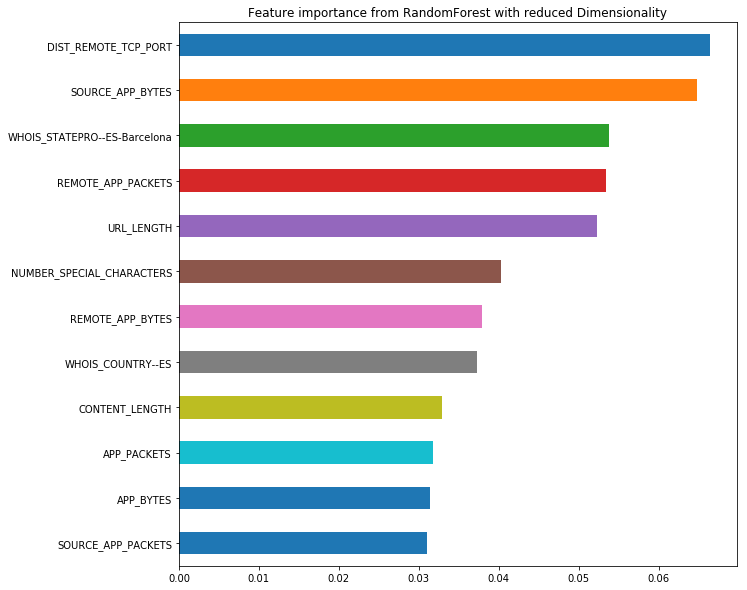

In [11]:
#feature_importance_with_dimentionality_reduction
pd.Series(rf_pp.feature_importances_, index = X_pp_train.columns).nlargest(12).plot(kind = 'barh',
                                                                               figsize = (10, 10),
                                                                              title = 'Feature importance from RandomForest with reduced Dimensionality').invert_yaxis();